# Channel Model Taxonomy project - Data Wrangling and Preprocessing

In [1]:
from ast import literal_eval
import pprint as pp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.spatial.distance import euclidean as dist
from mpl_toolkits.mplot3d import Axes3D
from pprint import pprint
import xml.etree.ElementTree as ET
import os
from collections import OrderedDict

%matplotlib inline

In [2]:
path2save = '/Users/vrhaynes/Desktop/research/data_analysis/meta/NeuroMLDBTools/data'
path2models = os.path.join(path2save,'models')
path2ephys = os.path.join(path2save,'ephys')

## Gather channel models from NeuroML-DB

Two ways to do this:

1) <b>"Unique" approach</b> - grab all models with id NMLCHXXXXXX (minimizes duplicates due to using the same plublished model, doesn't get rid of whether the channel models are equivalent but have different model files)
    - results in N=183 models with unique NMLCH tags

2) <b>"Model" approach</b> - go through each cell model, collect the channel types, grab the specific model, look up model ID in DB, then query for it (will get duplicates if the same channel model is used)
    - <include href="Im.channel.nml"></include> in cell model file
    - results in M>N (sum over channels in each cell model for a given channel type)
    - results in K>M but accounting for the different instances that channel is used in cell model if condDensity is include as part of channel features (this could be reflected not normalizing the channel responses for PCA).

In [3]:
def get_model(nmldb_id,save=False,path_to_save=None):
    '''
        NeuroML-DB API query for model
        
        TODO: Check if file is store already somewhere and load that instead of calling API.
        
        ----
        PARAMETER:
            - nmldb_id : (str) Contains NML ID 
            - save : (bool)
            - path_to_save : (str)
            
        OUTPUT:
            - mldb_model_response : (str) Contains all model specifications
    '''
    
    nmldb_xml_url = 'https://neuroml-db.org/render_xml_file?modelID='
    
    model_xml_url = nmldb_xml_url + nmldb_id
        
    model_xml_response = requests.get(model_xml_url)
    
    if save:
        xml_name = nmldb_id+'.xml'
        
        if path_to_save:
            filename = os.path.join(path_to_save,xml_name)
        else:
            filename = xml_name
        
        with open(filename, 'wb') as file:
            file.write(model_xml_response.content)

    return model_xml_response.text

In [4]:
def get_neuron_model_details(nmldb_id):
    
    if 'CH' in nmldb_id:
        raise Exception('NMLDB ID corresponds to a channel model!')
        
    elif nmldb_id in ['all']:
        nmldb_url = 'http://neuroml-db.org/api/models'
        
        nmldb_model_response = requests.get(nmldb_url)
    
    else:
        nmldb_url = 'http://neuroml-db.org/api/model?id='

        neuron_url = nmldb_url + nmldb_id

        nmldb_model_response = requests.get(neuron_url)
        
    
    return nmldb_model_response.json()

In [5]:
def get_channel_model_details(nmldb_id):
    
    if 'CL' in nmldb_id:
        raise Exception('NMLDB ID corresponds to a cell model!')
    
    elif nmldb_id in ['all']:
        nmldb_url = 'http://neuroml-db.org/api/models'
        
        nmldb_model_response = requests.get(nmldb_url)
    
    else:
        nmldb_url = 'http://neuroml-db.org/api/model?id='

        neuron_url = nmldb_url + nmldb_id

        nmldb_model_response = requests.get(neuron_url)
    
    return nmldb_model_response.json()

In [6]:
def create_channel_responses_df(ids,desired_var='Current',save_waveforms=False,save_models=False,path_to_models=None):
    ''' 
        Collects channel waveforms from NeuroML-DB. 
            1) query channel details for list of waveform ids.
            2) query api for actual waveform
            
        TODO: implement model file upload
        
        ----
        PARAMETER:
            - ids : (list/DataFrame) Contains NML IDs somewhere
            
        OUTPUT:
            - current_responses_df : (DataFrame) Contains each waveform for every model
        
    '''
    
    try: # if dataframe with more than 1 entry, get list of ids
        id_list = ids['Model_ID'].values.tolist() 
    
    except AttributeError: # if dataframe with only 1 entry, get id and put in list
        id_list = [ids['Model_ID']] 
        
    except TypeError: # if list of ids
        
        if type(ids) == list: # list of IDs case
            id_list = ids
                
        else: # single ID case - type(ids) == str
            id_list = [ids] 
    
    # instantiate dataframe object
    columns = ['Model_ID','Model_Name','Filename','Channel_Type','Protocol_ID','Start_Time','End_Time','Dt','Response_Type','Response_Values','Response_Times','Clamp_Label','Clamp_Values','Clamp_Times']
    channel_responses_df = pd.DataFrame(columns=columns)
    
    
    # iterate through channel ids to grab these
    for nmldb_id in id_list:
    
        # request models from https://neuroml-db.org/api/
        try:
            channel_model_details = get_channel_model_details(nmldb_id=nmldb_id)
        except ValueError:
            # if no JSON object can be decoded
            print('Model_ID: %s has no decodeable JSON file' %nmldb_id)
            
            # and skip this model
            continue
        except ConnectionError:
            # if connection was aborted
            print('Model_ID: %s connection aborted' %nmldb_id)
            
            # and skip this model
            continue
            
        print('Retrieved model details for NMLDB ID : %s' %nmldb_id)
            
        
#        # else
#         channel_model = get_model(nmldb_id=nmldb_id,
#                                         save=save_models,
#                                         path_to_save=path_to_models)


        # get desired details about channel traces
        model_filename = channel_model_details['model']['File_Name']
        model_name = channel_model_details['model']['Name']
        channel_type = channel_model_details['model']['Channel_Type']
        waveform_list = channel_model_details['waveform_list']
        
        # for current and voltage (these should correspond with one another)
        waveform_ids = [wave['ID'] for wave in waveform_list if wave['Variable_Name']==desired_var]
        start_times = [wave['Time_Start'] for wave in waveform_list if wave['Variable_Name']==desired_var]
        end_times = [wave['Time_End'] for wave in waveform_list if wave['Variable_Name']==desired_var]
        clamp_ids = [wave['ID'] for wave in waveform_list if wave['Variable_Name']=='Voltage']
        
        
        this_channel_vars = []
        this_channel_type = []
        this_channel_waveforms = []
        this_channel_names = []
        this_channel_protocols = []
        this_channel_clamp_labels = []
        this_channel_clamp_vals = []
        this_channel_filenames = []
        this_channel_ids = []
        this_channel_var_times = []
        this_channel_starts = []
        this_channel_ends = []
        this_channel_dts = []
        this_channel_clamp_times = []
        
        # current responses
        for waveform_id, start, end in zip(waveform_ids,start_times,end_times):
            this_waveform = get_model_waveform(waveform_id=waveform_id)
            
            t, var = this_waveform['Times'], this_waveform['Variable_Values']
            dt = this_waveform['dt_or_atol']
            
            # convert to numpy.array
            t, var = np.array(literal_eval(t)), np.array(literal_eval(var))
            
            # dataframe values
            this_channel_waveforms.append(var)
            this_channel_names.append(model_name)
            this_channel_filenames.append(model_filename)
            this_channel_type.append(channel_type)
            this_channel_ids.append(nmldb_id)
            this_channel_vars.append(desired_var)
            this_channel_var_times.append(t)
            
            this_channel_starts.append(start)
            this_channel_dts.append(dt)
            this_channel_ends.append(end)
            
        
        # voltage clamps
        for clamp_id in clamp_ids:
            this_waveform = get_model_waveform(waveform_id=clamp_id)
            
            protocol, clamp_label = this_waveform['Protocol_ID'],this_waveform['Waveform_Label']
            clamp_t, clamp_var = this_waveform['Times'], this_waveform['Variable_Values']
            
            # convert to numpy.array
            clamp_t, clamp_var = np.array(literal_eval(clamp_t)), np.array(literal_eval(clamp_var))
            
            this_channel_protocols.append(protocol)
            this_channel_clamp_labels.append(clamp_label)
            this_channel_clamp_times.append(clamp_t)
            this_channel_clamp_vals.append(clamp_var)
        
            
        # update channel traces dataframe
        df = pd.DataFrame(columns=columns)
        
        df['Model_ID'] = pd.Series(this_channel_ids)
        df['Model_Name'] = pd.Series(this_channel_names)
        df['Filename'] = pd.Series(this_channel_filenames)
        df['Channel_Type'] = pd.Series(this_channel_type)
        df['Protocol_ID'] = pd.Series(this_channel_protocols)
        df['Start_Time'] = pd.Series(this_channel_starts)
        df['End_Time'] = pd.Series(this_channel_ends)
        df['Dt'] = pd.Series(this_channel_dts)
        df['Response_Type'] = pd.Series(this_channel_vars)
        df['Response_Values'] = pd.Series(this_channel_waveforms)
        df['Response_Times'] = pd.Series(this_channel_var_times)
        df['Clamp_Label'] = pd.Series(this_channel_clamp_labels)
        df['Clamp_Values'] = pd.Series(this_channel_clamp_vals)
        df['Clamp_Times'] = pd.Series(this_channel_clamp_times)
        
        join_frames = [channel_responses_df,df]
        channel_responses_df = pd.concat(join_frames,ignore_index=True)
            
            
            
    return channel_responses_df
                 
    

In [7]:
def get_model_waveform(waveform_id):
    
    waveform_url = 'http://neuroml-db.org/api/waveform?id=%s' %waveform_id

    nmldb_waveform_response = requests.get(waveform_url)
    
    return nmldb_waveform_response.json()

In [8]:
def import_model(nmldb_id,path_to_models=None):
    
    # first check if model file exists
    filename = nmldb_id + '.xml'
    model_file = os.path.join(path_to_models,filename)
    print(model_file)
    
    if os.path.isfile(model_file):
        
        model = ET.parse(model_file)
        return model
    
    else:
        print('No model with NMLDB ID: %s exists!' %nmldb_id)
    

In [9]:
def query_model_by_keyword(keyword):
    
    nmldb_url = 'http://neuroml-db.org/api/search?q='
    
    keyword_url = nmldb_url + keyword

    nmldb_keyword_response = requests.get(keyword_url)
    
    
    return nmldb_keyword_response.json()

In [10]:
keyword_search = query_model_by_keyword('"Type":"Channel"') # randomly returns 25 of these

### Unique approach

In [11]:
NMLDB_ID = 'NMLCH000001'

In [12]:
example_channel_model = get_channel_model_details(NMLDB_ID)

In [13]:
example_channel_model


{u'children': [],
 u'complexity': {u'cvode_spikes_vs_steps': [], u'dt_sensitivity': []},
 u'ephyz_clusters': [],
 u'keywords': [],
 u'model': {u'AP12AHPDepthPercentChange': None,
  u'AP12AmplitudeChangePercent': None,
  u'AP12AmplitudeDrop': None,
  u'AP12HalfWidthChangePercent': None,
  u'AP12RateOfChangePeakToTroughPercentChange': None,
  u'AP1AHPDepth': None,
  u'AP1Amplitude': None,
  u'AP1DelayMean': None,
  u'AP1DelayMeanStrongStim': None,
  u'AP1DelaySD': None,
  u'AP1DelaySDStrongStim': None,
  u'AP1RateOfChangePeakToTrough': None,
  u'AP1SSAmplitudeChange': None,
  u'AP1WidthHalfHeight': None,
  u'AP1WidthPeakToTrough': None,
  u'AP2AHPDepth': None,
  u'AP2Amplitude': None,
  u'AP2DelayMean': None,
  u'AP2DelayMeanStrongStim': None,
  u'AP2DelaySD': None,
  u'AP2DelaySDStrongStim': None,
  u'AP2RateOfChangePeakToTrough': None,
  u'AP2WidthHalfHeight': None,
  u'AP2WidthPeakToTrough': None,
  u'AccommodationAtSSMean': None,
  u'AccommodationRateMeanAtSS': None,
  u'Accommodatio

In [14]:
example_channel_model.keys()

[u'publication',
 u'versions',
 u'ephyz_clusters',
 u'waveform_list',
 u'complexity',
 u'references',
 u'neurolex_ids',
 u'keywords',
 u'parents',
 u'model',
 u'similar_cells',
 u'children']

In [15]:
example_channel_model['model']['Channel_Type']

u'Ih'

In [16]:
example_channel_model['neurolex_ids']

[{u'Comments': None,
  u'NeuroLex_ID': 3000004,
  u'NeuroLex_Term': u'Hyperpolarization Activated Cyclic Nucleotide Gated Channel, HCN',
  u'NeuroLex_URI': u'nifext_2516'},
 {u'Comments': None,
  u'NeuroLex_ID': 3001803,
  u'NeuroLex_Term': u'I h, Inward rectifier, Anomalous Rectifier, Funny Current, Hyperpolarization Activated, Mixed Cation Current',
  u'NeuroLex_URI': u'oen_0001301'}]

In [17]:
example_channel_model['parents']

[{u'CVODE_Benchmark_RunTime': 183.05165891276184,
  u'CVODE_baseline_step_frequency': 13583.6054159521,
  u'CVODE_steps_per_spike': 373.497044412559,
  u'Directory_Path': u'/var/www/NeuroMLmodels/NMLCL000001',
  u'Equations': 27019,
  u'Errors': None,
  u'File': u'/var/www/NeuroMLmodels/NMLCL000001/CA1.cell.nml',
  u'File_MD5_Checksum': u'98ef18b8d4e5b86e918b25e472b42c7c',
  u'File_Name': u'CA1.cell.nml',
  u'File_Updated': u'2017-05-09T00:00:00-07:00',
  u'ID_Helper': 140,
  u'Max_Stable_DT': 0.03125,
  u'Max_Stable_DT_Benchmark_RunTime': 202.9376941568717,
  u'Max_Stable_DT_Error': 4.23593477303011,
  u'Model_ID': u'NMLCL000001',
  u'Name': u'CA1 Pyramidal Cell',
  u'Notes': u'None',
  u'Optimal_DT': 0.00552569485506138,
  u'Optimal_DT_Benchmark_RunTime': 1147.6932962726542,
  u'Optimal_DT_Error': 1.97487775905919,
  u'Optimal_DT_a': 0.000961538461538461,
  u'Optimal_DT_b': 31.4914649639909,
  u'Optimal_DT_c': 0.134350854947566,
  u'Publication_ID': 6000001,
  u'Runtime_Per_Step': 0.

In [18]:
example_channel_model['model']['Name']

u'Ih Hyperpolarization Activated Cation'

In [19]:
example_channel_model['ephyz_clusters'] # empty

[]

In [20]:
# all waveforms model was subjected to
example_channel_model['waveform_list']

[{u'ID': 398144,
  u'Meta_Protocol': None,
  u'Meta_Protocol_ID': None,
  u'Protocol': u'Activation',
  u'Protocol_ID': u'ACTIVATION',
  u'Starts_From_Steady_State': 0,
  u'Time_End': 2130.0,
  u'Time_Start': 0.0078125,
  u'Units': u'mV',
  u'Variable_Name': u'Voltage',
  u'Waveform_Label': u'-150.0 mV'},
 {u'ID': 398145,
  u'Meta_Protocol': None,
  u'Meta_Protocol_ID': None,
  u'Protocol': u'Activation',
  u'Protocol_ID': u'ACTIVATION',
  u'Starts_From_Steady_State': 0,
  u'Time_End': 2130.0,
  u'Time_Start': 0.0078125,
  u'Units': u'pS',
  u'Variable_Name': u'Conductance',
  u'Waveform_Label': u'-150.0 mV'},
 {u'ID': 398146,
  u'Meta_Protocol': None,
  u'Meta_Protocol_ID': None,
  u'Protocol': u'Activation',
  u'Protocol_ID': u'ACTIVATION',
  u'Starts_From_Steady_State': 0,
  u'Time_End': 2130.0,
  u'Time_Start': 0.0078125,
  u'Units': u'pA',
  u'Variable_Name': u'Current',
  u'Waveform_Label': u'-150.0 mV'},
 {u'ID': 398147,
  u'Meta_Protocol': None,
  u'Meta_Protocol_ID': None,
  u

In [21]:
# Divide waveform categories into ACTIVATION, INACTIVATION, and DEACTIVATION
activation_waveforms = [waveform for waveform in example_channel_model['waveform_list'] if waveform['Protocol_ID']==u'ACTIVATION']
inactivation_waveforms = [waveform for waveform in example_channel_model['waveform_list'] if waveform['Protocol_ID']==u'INACTIVATION']
deactivation_waveforms = [waveform for waveform in example_channel_model['waveform_list'] if waveform['Protocol_ID']==u'DEACTIVATION']

In [22]:
activation_waveforms

[{u'ID': 398144,
  u'Meta_Protocol': None,
  u'Meta_Protocol_ID': None,
  u'Protocol': u'Activation',
  u'Protocol_ID': u'ACTIVATION',
  u'Starts_From_Steady_State': 0,
  u'Time_End': 2130.0,
  u'Time_Start': 0.0078125,
  u'Units': u'mV',
  u'Variable_Name': u'Voltage',
  u'Waveform_Label': u'-150.0 mV'},
 {u'ID': 398145,
  u'Meta_Protocol': None,
  u'Meta_Protocol_ID': None,
  u'Protocol': u'Activation',
  u'Protocol_ID': u'ACTIVATION',
  u'Starts_From_Steady_State': 0,
  u'Time_End': 2130.0,
  u'Time_Start': 0.0078125,
  u'Units': u'pS',
  u'Variable_Name': u'Conductance',
  u'Waveform_Label': u'-150.0 mV'},
 {u'ID': 398146,
  u'Meta_Protocol': None,
  u'Meta_Protocol_ID': None,
  u'Protocol': u'Activation',
  u'Protocol_ID': u'ACTIVATION',
  u'Starts_From_Steady_State': 0,
  u'Time_End': 2130.0,
  u'Time_Start': 0.0078125,
  u'Units': u'pA',
  u'Variable_Name': u'Current',
  u'Waveform_Label': u'-150.0 mV'},
 {u'ID': 398147,
  u'Meta_Protocol': None,
  u'Meta_Protocol_ID': None,
  u

<b>Notes:</b>
> 1. Each protocol has a different "Time_End" so they are not the same duration
> 2. Details about protocol are not include, for example, what is the time stamp for inactivation/deactivation?

In [23]:
wave_types = [wave['Variable_Name'] for wave in activation_waveforms]

print('Types of wave responses: %s '%np.unique(wave_types) )

print('Number of wave responses: %s' % len(wave_types))

Types of wave responses: [u'Conductance' u'Current' u'Voltage'] 
Number of wave responses: 33


I've saved all model details from the database in a *.py file. 

## Collect the channel model properties

<b>Objectives</b>
> 1. 

In [11]:
# get some model info from store list
temp_tags_filename = os.path.join(path2models,'channel_tags.csv') # not complete
temp_tags_df = pd.read_csv(temp_tags_filename)


In [12]:
temp_tags_df.tail()

,Web_ID,Filename,Protocol
134,/www/NeuroMLmodels/NMLCH000168/,napf_spinstell.channel.nml,Na
135,/www/NeuroMLmodels/NMLCH000169/,napf_tcr__a0__b0__c0__d0__fastNa_shift7.channe...,Na
136,/www/NeuroMLmodels/NMLCH000170/,napf_tcr.channel.nml,Na
137,/www/NeuroMLmodels/NMLCH000171/,napf.channel.nml,Na
138,/www/NeuroMLmodels/NMLCH000172/,pas.channel.nml,NaN


In [13]:
# replace Web_ID with Model_ID
columns = ['Model_ID','Filename','Protocol']
channel_tags_df = pd.DataFrame(columns=columns)

nmldb_ids = []

for web_str in temp_tags_df.Web_ID.values:
    
    model_id = web_str.split('/')[-2]
    nmldb_ids.append(model_id)
    
    
channel_tags_df['Model_ID'] = pd.Series(nmldb_ids)
channel_tags_df['Filename'] = temp_tags_df.Filename
channel_tags_df['Protocol'] = temp_tags_df.Protocol

In [16]:
all_model_details = get_channel_model_details('all')

In [17]:
all_channel_details = []

for model_details in all_model_details:
    
    if model_details['Type'] in ['CH']:
        all_channel_details.append(model_details)

In [18]:
all_channel_details[0]

{u'CVODE_Benchmark_RunTime': None,
 u'CVODE_baseline_step_frequency': None,
 u'CVODE_steps_per_spike': None,
 u'Directory_Path': u'/var/www/NeuroMLmodels/NMLCH000001',
 u'Equations': 2,
 u'Errors': None,
 u'File': u'/var/www/NeuroMLmodels/NMLCH000001/hd.nml',
 u'File_MD5_Checksum': u'391306c88b6f957a9d97a435bfc82e0d',
 u'File_Name': u'hd.nml',
 u'File_Updated': u'2017-05-09T00:00:00-07:00',
 u'ID_Helper': 1,
 u'Max_Stable_DT': None,
 u'Max_Stable_DT_Benchmark_RunTime': None,
 u'Max_Stable_DT_Error': None,
 u'Model_ID': u'NMLCH000001',
 u'Name': u'Ih Hyperpolarization Activated Cation',
 u'Notes': u'Species was changed to h from hd',
 u'Optimal_DT': None,
 u'Optimal_DT_Benchmark_RunTime': None,
 u'Optimal_DT_Error': None,
 u'Optimal_DT_a': None,
 u'Optimal_DT_b': None,
 u'Optimal_DT_c': None,
 u'Publication_ID': 6000001,
 u'Runtime_Per_Step': 1.30326823376724e-06,
 u'Status': u'CURRENT',
 u'Status_Timestamp': u'2018-07-05T14:19:45-07:00',
 u'Type': u'CH',
 u'Upload_Time': u'2012-12-21T0

In [19]:
model_ids = []
filenames = []
model_names = []

for channel in all_channel_details:
    
    model_ids.append(channel['Model_ID'])
    filenames.append(channel['File_Name'])
    model_names.append(channel['Name'])
    
channel_tags_df = pd.DataFrame(columns=['Model_ID','Model_Name','Filename'])

channel_tags_df['Model_ID'] = pd.Series(model_ids)
channel_tags_df['Model_Name'] = pd.Series(model_names)
channel_tags_df['Filename'] = pd.Series(filenames)

In [20]:
channel_tags_df.to_csv(temp_tags_filename)
channel_tags_df.tail()

,Model_ID,Model_Name,Filename
178,NMLCH001638,IA A-Type Potassium,KvAproxp.channel.nml
179,NMLCH001639,KCa AHP Type Calcium Dependent Potassium,KvCaB.channel.nml
180,NMLCH001641,Na Sodium,Navbis.channel.nml
181,NMLCH001645,Na Sodium,Navapicalp.channel.nml
182,NMLCH001649,Ih Hyperpolarization Activated Cation (HCN),HCNsomap.channel.nml


## Example with small number of models

In [25]:
channel_nmdlb_id_list = ["NMLCH000001","NMLCH000003","NMLCH000004"]

In [26]:
example_clamp_waveform = get_model_waveform(398144)


In [27]:
example_clamp_waveform

{u'CVODE_active': 0,
 u'ID': 398144,
 u'Max': -40.0,
 u'Mean': -71.431,
 u'Meta_Protocol_ID': None,
 u'Min': -150.0,
 u'Model_ID': u'NMLCH000001',
 u'Percent_Error': None,
 u'Protocol_ID': u'ACTIVATION',
 u'Run_Time': 0.596527814865112,
 u'STD': 49.6913989079455,
 u'Spikes': 0,
 u'Steps': 272642,
 u'Time_End': 2130.0,
 u'Time_Start': 0.0078125,
 u'Times': u'0.0078125,100.0,100.015625,2100.0,2100.0078125,2100.015625,2130.0\n',
 u'Timestamp': u'2018-06-29T03:49:55-07:00',
 u'Units': u'mV',
 u'Variable_Name': u'Voltage',
 u'Variable_Values': u'-40.003,-40.0,-150.0,-150.0,-40.014,-40.0,-40.0\n',
 u'Waveform_Label': u'-150.0 mV',
 u'dt_or_atol': 0.01171875}

In [28]:
example_current_waveform = get_model_waveform(398149)

In [29]:
example_current_waveform

{u'CVODE_active': 0,
 u'ID': 398149,
 u'Max': 4.986,
 u'Mean': -48.00900878125,
 u'Meta_Protocol_ID': None,
 u'Min': -89.894,
 u'Model_ID': u'NMLCH000001',
 u'Percent_Error': None,
 u'Protocol_ID': u'ACTIVATION',
 u'Run_Time': 0.649824857711792,
 u'STD': 38.2563661602277,
 u'Spikes': 2,
 u'Steps': 272642,
 u'Time_End': 2130.0,
 u'Time_Start': 0.0078125,
 u'Times': u'0.0078125,0.015625,2.0703125,4.234375,9.15625,15.0625,22.484375,30.8125,42.5078125,100.0078125,100.015625,100.265625,100.6953125,101.1328125,101.859375,102.6171875,103.359375,104.125,104.515625,104.9140625,105.3203125,105.734375,106.1484375,106.5703125,107.0,107.4375,107.8828125,108.3359375,108.796875,109.2734375,109.7578125,110.25,110.75,111.265625,111.7890625,112.328125,112.875,113.4375,113.984375,114.5390625,115.1171875,115.703125,116.3046875,116.921875,117.5546875,118.203125,118.875,119.5625,120.2734375,121.0,121.75,122.53125,123.3359375,124.171875,125.015625,125.8984375,126.8125,127.7578125,128.7421875,129.7734375,130.

## Collect the "raw" current responses and voltage clamp details for each channel model

<b>Objectives</b>
> 1. Get a channel model details with API
> 2. Collect response details
> 3. Collect voltage clamp details
> 4. Store and save in dataframe

In [30]:
current_responses_df = create_channel_responses_df(ids=channel_nmdlb_id_list)

Retrieved model details for NMLDB ID : NMLCH000001
Retrieved model details for NMLDB ID : NMLCH000003
Retrieved model details for NMLDB ID : NMLCH000004


In [ ]:
current_responses_df.tail(10)

In [ ]:
protocol = 'DEACTIVATION'
model = 'NMLCH000004'

this_protocol_df = current_responses_df[current_responses_df['Protocol_ID']==protocol]
this_channel_protocol_df = this_protocol_df[this_protocol_df['Model_ID']==model]


fig,axes = plt.subplots(3,1,figsize=(11,7))

for i, (curr_times,curr_response,curr_clamp,clamp_times) in enumerate(zip(this_channel_protocol_df.Response_Times.values,this_channel_protocol_df.Response_Values.values,this_channel_protocol_df.Clamp_Values.values,this_channel_protocol_df.Clamp_Times.values)):
    
#     print(this_channel_protocol_df.Clamp_Label.values[i])
#     print('# of response points = %s' %len(curr_response)) 
#     print('# of clamp points = %s' %len(curr_clamp))
    
    if not i>0:
        total_response = curr_response
        total_clamp = curr_clamp
    else:
        total_response = np.concatenate((total_response,curr_response),axis=None)
        total_clamp = np.concatenate((total_clamp,curr_clamp),axis=None)
    
    axes[0].plot(curr_times,curr_response)
    axes[0].set_title('Not Interpolated Current Responses')
    axes[0].set_ylabel('Current (pA)')
    axes[0].set_xlabel('Sampled pts')

    axes[1].plot(clamp_times,curr_clamp)
    axes[1].set_title('Not Interpolated Voltage Clamp Steps')
    axes[1].set_ylabel('Voltage (mV)')
    axes[1].set_xlabel('Sampled pts')

    axes[2].plot(clamp_times,'ko')
    axes[2].plot(clamp_times)
    axes[2].set_title('Stored Clamp Time Points')
    axes[2].set_ylabel('Times (ms)')
    axes[2].set_xlabel('Sampled pts')

fig.tight_layout()
plt.suptitle('Traces for Model_ID=%s, Protocol_ID=%s' %(model,protocol),y=1.02,size='x-large')

In [ ]:
plt.plot(total_response)
plt.title('Not Interpolated Appended Current Response')

## Select interval of interest for each protocol type and voltage steps

<b>Objectives:</b>
> 1. Interpolate current responses based on clamp val and t points
    > linear interpolation seems to work fine for the sampling method Justas used
> 2. Define desired interval for each protocol
> 3. For desired interval, subsample the current response to a fixed amount
> 4. Append each subsampled current response into one long response for each protocol
> 5. Store and save in dataframe

In [24]:
from scipy.interpolate import interp1d

In [ ]:
fig,axes = plt.subplots(1,2,figsize=(16,3))
shift = 0

for trace_id in range(11):

    dt = this_channel_protocol_df['Dt'].values[trace_id]
    t0 = this_channel_protocol_df['Start_Time'].values[trace_id]
    tf = this_channel_protocol_df['End_Time'].values[trace_id]

    num_pts = int(np.ceil((tf-t0)/dt))


    t_interp = np.linspace(t0,tf,num_pts)
    dt_interp = t_interp[1]-t_interp[0]

    curr_response = this_channel_protocol_df['Response_Values'].values[trace_id]
    curr_times = this_channel_protocol_df['Response_Times'].values[trace_id]

    clamp_vals = this_channel_protocol_df['Clamp_Values'].values[trace_id]
    clamp_times = this_channel_protocol_df['Clamp_Times'].values[trace_id]

    response_interp = interp1d(curr_times,curr_response,kind='linear')
    clamp_interp = interp1d(clamp_times,clamp_vals,kind='linear')

    axes[0].plot(curr_times,curr_response,'ko',t_interp,response_interp(t_interp),'-')
    # axes[0].set_ylim([-120,20]) # this agrees with image in database, note that on database you can't zoom in on the y axis, only x
    axes[0].set_title('Interpolated Current Responses')

    axes[1].plot(clamp_times,clamp_vals,'ko',t_interp,clamp_interp(t_interp),'-')
    axes[1].set_title('Interpolated Voltage Clamps')
    
    if np.max(curr_response)>shift:
        shift = np.max(curr_response)

plt.suptitle('Model_ID = %s | Protocol_ID = %s' %(model,protocol),y=1.03)

In [ ]:
clamp_times

In [ ]:
t_interp

### Intervals of Interest - definitions

> - Activation = time of first current step to end of protocol = (T1,T1+T2+T3)
>    > This protocol has 3 step intervals corresponding to T1,T2 (graded activation), T3
> - Inactivation = time after initial Activation interval to end = (T1+T2,T1+T2+T3+T4)
>    > This protocol has 4 step intervals corresponding to T1,T2 (graded activation), T3 (deactivation), T4 (inactivation)
> - Deactvation = time between initial Activation and before Inactivation = (T1+T2,T1+T2+T3)
>    > This protocol only has 3 step intervals corresponding to T1,T2 (activation), T3 (graded deactivation), T4 (inactivation)
>
>

<b>Notes:</b>

> - T1,2,3,4 are stored in the "Clamp_Times" with one addition point, T0
> - This isn't exactly like the ICGeneology intervals. They make specific changes depending on the ion species
>> 1. Example: the intial activation interval point for NaV and CaV = T1 - 2 ms
>> 2. Example: the activation end points for KCa and Ih = (T1+T2+T3) - 95 ms

In [ ]:
current_responses_df

In [ ]:
current_responses_df.head(33)

In [20]:
def create_clamp_times_df(responses_df):

    model_ids = np.unique(responses_df.Model_ID.values).tolist()
    protocol_ids = np.unique(responses_df.Protocol_ID.values).tolist()

    columns = ['Model_ID','Protocol_ID','Clamp_Times']
    clamp_times_df = pd.DataFrame(columns=columns)

    # get the model-specific step times for each protocol
    for model in model_ids:

        this_model_df = responses_df[responses_df['Model_ID']==model]

        for protocol in protocol_ids:
            
            all_clamp_times = []

            this_protocol_df = this_model_df[this_model_df['Protocol_ID']==protocol]
            all_sampled_times = this_protocol_df.Clamp_Times.values

            
            for sampled_times in all_sampled_times:

                desired_times = np.unique([int(i) for i in sampled_times]).tolist()
                all_clamp_times.append(desired_times)
                
            # grab the largest of these (to avoid cases when the voltage step is 0 => no time point)
            lengths = [len(clamp_times) for clamp_times in all_clamp_times]
            max_length = np.max(lengths)
            desired_idx = np.where((lengths==max_length))[0][0] # first index is fine
            
            desired_clamp_times = all_clamp_times[desired_idx]
            
            
            df = pd.DataFrame(columns=columns)
            
            df['Model_ID'] = pd.Series(model)
            df['Protocol_ID'] = pd.Series(protocol)
            df['Clamp_Times'] = pd.Series([desired_clamp_times])
            
            
            join_frames = [clamp_times_df,df]
            clamp_times_df = pd.concat(join_frames,ignore_index=True)

            
    return clamp_times_df
                

In [33]:
def get_sample_intervals_of_interest(responses_df,num_samples=512,interpolate=True,interp_method='linear'):
    '''
        Subsamples points in intervals of interest for responses. If interpolation is needed, linear interpolation
        is applied to each timeseries with a resolution equivalent to that given from the subsampling rate.
        
        NOTE: responses_df should only contain one channel model for now.
        
        TODO: Subsampling is not implemented. Only interpolation.
        
        ----
        PARAMETERS:
            - response_df : (pandas.DataFrame) contains responses that need to be subsampled
            - interpolate : (bool) whether to interpolate when data are sparsely stored (default:True)
            
        OUTPUT:
            - samples : (numpy.array) contains an NxT matrix of subsampled data 
                                      (N = # of responses, T = # of sample points)
        
    
    '''
    
    # protocol details (should match dictionary)
    protocol_ids = np.unique(responses_df.Protocol_ID.values).tolist()
    
    protocol_intervals = {
        'ACTIVATION'   : [1,3],    
        'INACTIVATION' : [2,4], 
        'DEACTIVATION' : [2,3]    
    }
    
    # check whether an interval is not defined for each protocols (empty list otherwise)
    intervals_defined = [False for key in protocol_ids if key not in protocol_intervals.keys()]
    
    if not all(intervals_defined):
        raise Exception('%s Protocol_ID(s) have no interval defined!' %len(intervals_defined))
    
    
    # sampling parameters
#     num_samples = 512 
#     interp_method = 'linear'
    
    # instantiate matrix to return
    num_responses = len(responses_df.index.values)
    response_samples = np.zeros((num_responses,num_samples))
    response_times = np.zeros((num_responses,num_samples))

    # get clamp times
    clamp_times_df = create_clamp_times_df(responses_df)
    
    # for each current trace get the desired subinterval
    for trace_id in range(num_responses):
        
        protocol_id = responses_df['Protocol_ID'].values[trace_id]
        model_id = responses_df['Model_ID'].values[trace_id]
        
        # collect interval points
        this_model_df = clamp_times_df[clamp_times_df['Model_ID']==model_id]
        this_model_protocol_df = this_model_df[this_model_df['Protocol_ID']==protocol_id]
        
        desired_clamp_times = this_model_protocol_df.iloc[0]['Clamp_Times']
        
        t0, tf = protocol_intervals[protocol_id]
        T0, Tf = desired_clamp_times[t0], desired_clamp_times[tf]
        
        # interpolate if desired
        if interpolate:
            
            t_interp = np.linspace(T0,Tf,num_samples)
            dt_interp = t_interp[1]-t_interp[0]

            curr_response = responses_df['Response_Values'].values[trace_id]
            curr_times = responses_df['Response_Times'].values[trace_id]
            
            # linear, 1D interpolation
            response_interp = interp1d(curr_times,curr_response,kind=interp_method)
            
            # store for return
            response_times[trace_id,:] = t_interp
            response_samples[trace_id,:] = response_interp(t_interp)
        else:
            raise Exception('No other subsampling method implemented - set: interpolate=True')

            
            
    return response_times, response_samples




In [23]:
response_times,response_samples = get_sample_intervals_of_interest(current_responses_df)

# make new dataframe that will be source of PCA info
dropped_columns = ['Start_Time','End_Time','Dt','Response_Values','Response_Times','Clamp_Values','Clamp_Times']

interp_responses_df = current_responses_df.drop(labels=dropped_columns,axis='columns')

interp_responses_df['Response_Values'] = pd.Series([response for response in response_samples])
interp_responses_df['Response_Times'] = pd.Series([times for times in response_times])

NameError: name 'current_responses_df' is not defined

In [ ]:
interp_responses_df.tail()

In [ ]:
columns = interp_responses_df.columns.values
appended_responses_df = pd.DataFrame(columns=columns)

appended_responses_df = appended_responses_df.drop(labels=['Model_Name','Filename','Response_Type','Clamp_Label','Response_Times'],axis='columns')
new_columns = appended_responses_df.columns.values


unique_models = np.unique(interp_responses_df['Model_ID'].values)

for model_id in unique_models:
    
    
    this_model_df = interp_responses_df[interp_responses_df['Model_ID']==model_id]
    unique_protocols = np.unique(this_model_df['Protocol_ID'].values)
    
    for protocol_id in unique_protocols:
        
        this_model_protocol_df = this_model_df[this_model_df['Protocol_ID']==protocol_id]
        
        channel_type = this_model_protocol_df['Channel_Type'].values
        
        for i, curr_response in enumerate(this_model_protocol_df.Response_Values.values):
            
            # check if negative deflection from baseline (first point)
            curr_min = np.min(curr_response)
            
            if curr_min < curr_response[0]:
                curr_response*=-1 # reverse inward current
            
            # if first current response start total response
            if not i>0:
                total_response = curr_response
            else:
                total_response = np.concatenate((total_response,curr_response),axis=None)
                
                
                

        df = pd.DataFrame(columns=new_columns)
        df['Model_ID'] = pd.Series(model_id)
        df['Protocol_ID'] = pd.Series(protocol_id)
        df['Channel_Type'] = pd.Series(channel_type)
        df['Response_Values'] = pd.Series([total_response])
        
        join_frames = [appended_responses_df,df]
        appended_responses_df = pd.concat(join_frames,ignore_index=True)
        

In [ ]:
appended_responses_df

In [ ]:
fig, axes = plt.subplots(3,1,figsize=(16,6),sharex=True)

plot_this = 3
axes[0].plot(appended_responses_df.Response_Values.values[plot_this])
axes[0].set_title('%s response for Model_ID : %s' %(appended_responses_df.Protocol_ID.values[plot_this],appended_responses_df.Model_ID.values[plot_this]))
axes[0].set_ylabel('Current (pA)')

plot_this = 4
axes[1].plot(appended_responses_df.Response_Values.values[plot_this])
axes[1].set_title('%s response for Model_ID : %s' %(appended_responses_df.Protocol_ID.values[plot_this],appended_responses_df.Model_ID.values[plot_this]))
axes[1].set_ylabel('Current (pA)')

plot_this = 5
axes[2].plot(appended_responses_df.Response_Values.values[plot_this])
axes[2].set_title('%s response for Model_ID : %s' %(appended_responses_df.Protocol_ID.values[plot_this],appended_responses_df.Model_ID.values[plot_this]))
axes[2].set_ylabel('Current (pA)')

axes[2].set_xlabel('Samples')
fig.tight_layout()


## Repeat above for all channel models then perform agglomerative clustering

<b>Objectives:</b>
> 1. Gather all channel models in database
> 2. Create appended response dataframe
> 3. Normalize each appended response
> 4. Perform PCA for dimensionality reduction
> 5. Perform hierarchical clustering

In [ ]:
channel_tags_df.tail()

## Actual data wrangling pipeline (Repeat above but cleaner)

In [31]:
# load if already saved dataframes
filename = os.path.join(path2save,'channel_tags.csv')
channel_tags_df = pd.read_csv(filename)

filename = os.path.join(path2save,'current_responses.pkl')
current_responses_df = pd.read_pickle(filename)


# # need to remake this with negative deflection correction
# filename = os.path.join(path2save,'appended_responses.pkl')
# appended_responses_df = pd.read_pickle(filename)

In [83]:
# get intervals of interest for each response and interpolate
response_times,response_samples = get_sample_intervals_of_interest(current_responses_df)

# make new dataframe with minimal information
dropped_columns = ['Start_Time','End_Time','Dt','Response_Values','Response_Times','Clamp_Values','Clamp_Times']
interp_responses_df = current_responses_df.drop(labels=dropped_columns,axis='columns')

interp_responses_df['Response_Values'] = pd.Series([response for response in response_samples])
interp_responses_df['Response_Times'] = pd.Series([times for times in response_times])


# make a dataframe with appended responses for dimensionality reduction
columns = interp_responses_df.columns.values
appended_responses_df = pd.DataFrame(columns=columns)

appended_responses_df = appended_responses_df.drop(labels=['Model_Name','Filename','Response_Type','Clamp_Label','Response_Times'],axis='columns')
new_columns = appended_responses_df.columns.values

# Append responses and reduce interpolated responses in dataframe for each unique model
unique_models = np.unique(interp_responses_df['Model_ID'].values)

for model_id in unique_models:
    
    this_model_df = interp_responses_df[interp_responses_df['Model_ID']==model_id]
    unique_protocols = np.unique(this_model_df['Protocol_ID'].values)
    
    for protocol_id in unique_protocols:
        
        this_model_protocol_df = this_model_df[this_model_df['Protocol_ID']==protocol_id]
        channel_type = this_model_protocol_df['Channel_Type'].values
        
        for i, curr_response in enumerate(this_model_protocol_df.Response_Values.values):
            
            # check if negative deflection from baseline (first point)
            # I could also try out checking relative to the mode
            curr_min = np.min(curr_response)
#             if model_id in ['NMLCH001645'] and protocol_id in ['ACTIVATION']:
#                 print(curr_min)
            
            # sometimes current hovers below zero but barely, e.g., at -0.002 pA
            # so look for a large current deflection
            if curr_min < -0.1:  # TODO!--- redo b/c -0.1 does not catch deflection of ~-0.06 
                
                curr_response*=-1 # reverse inward current
                 
            if i==0:
                total_response = curr_response
            else:
                total_response = np.concatenate((total_response,curr_response),axis=None)
                
                
        
#         # !--- Added normalization here NORMALIZE (Need to rerun if decide to do here)
#         max_response = np.max(total_response)  
#         norm_total_response = (total_response/max_response).tolist()

        df = pd.DataFrame(columns=new_columns)
        df['Model_ID'] = pd.Series(model_id)
        df['Protocol_ID'] = pd.Series(protocol_id)
        df['Channel_Type'] = pd.Series(channel_type)
        df['Response_Values'] = pd.Series([norm_total_response])
        
        
        join_frames = [appended_responses_df,df]
        appended_responses_df = pd.concat(join_frames,ignore_index=True)
        
        

-7.5371e-09
-3.424764946183953e-06
-0.001435393476842792
-0.37198739073711673
-10.977647749510762
-25.05297847358127
-27.175
-18.660149119373806
-7.54663140900197
-0.026797510763213038
-0.027841177103722626


In [82]:
current_responses_df.tail(1)

,Model_ID,Model_Name,Filename,Channel_Type,Protocol_ID,Start_Time,End_Time,Dt,Response_Type,Response_Values,Response_Times,Clamp_Label,Clamp_Values,Clamp_Times
9206,NMLCH001649,Ih Hyperpolarization Activated Cation (HCN),HCNsomap.channel.nml,Ih,INACTIVATION,0.007812,1500.0,0.011719,Current,"[-0.0, 0.35506, 0.25941, 0.18363, 0.12492, 0.0...","[0.0078125, 0.015625, 3.1171875, 6.5625, 10.47...",-40.0 mV,"[-40.003, -40.0, -120.0, -120.0, -40.0, -40.0]","[0.0078125, 1100.0, 1100.015625, 1400.0, 1400...."


In [80]:
appended_responses_df.tail()

,Model_ID,Channel_Type,Protocol_ID,Response_Values
544,NMLCH001645,Na,DEACTIVATION,"[-2.000303722397433e-06, 0.12949032485323902, ..."
545,NMLCH001645,Na,INACTIVATION,"[0.04457501804658516, 7.580570384865502, 4.193..."
546,NMLCH001649,Ih,ACTIVATION,"[-0.00872565460597826, 59.25032191780822, 85.1..."
547,NMLCH001649,Ih,DEACTIVATION,"[94.98499998905704, -22.361763054896105, -10.9..."
548,NMLCH001649,Ih,INACTIVATION,"[104.99999991765345, 74.98608914309027, 74.974..."


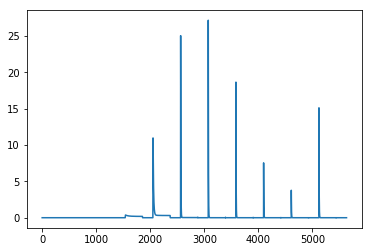

In [89]:
plt.plot(appended_responses_df['Response_Values'].iloc[543])

In [90]:
# save everything before moving on
filename = os.path.join(path2save,'channel_tags.csv')
channel_tags_df.to_csv(filename)

filename = os.path.join(path2save,'current_responses.pkl')
current_responses_df.to_pickle(filename)

filename = os.path.join(path2save,'appended_responses.pkl')
appended_responses_df.to_pickle(filename)

In [91]:
np.unique(appended_responses_df.Channel_Type).tolist()

[u'Cav', u'Ih', u'KCa', u'Kca', u'Kv', u'Na', u'pas']

Use when I can actually get real Channel_Type

In [92]:
# tag broad class of channels and group
channel_classes = np.unique(appended_responses_df.Channel_Type).tolist()
response_lengths = np.zeros(len(channel_classes))

# separate channel-type specific
for i, channel_type in enumerate(channel_classes):
    
    channel_df = appended_responses_df[appended_responses_df['Channel_Type']==channel_type]
    
    # grab length of first one
    length = len(channel_df.iloc[0].Response_Values)
    
    # update length
    response_lengths[i] = length
    

In [93]:
# construct the channel-type specific PCA matrices

# Cav
columns = []
for i in range(int(response_lengths[0])):
    columns.append(str(i))

columns.append('Model_ID')
columns.append('Protocol_ID')

cav_pca_df = pd.DataFrame(columns=columns)


# Ih
columns = []
for i in range(int(response_lengths[1])):
    columns.append(str(i))

columns.append('Model_ID')
columns.append('Protocol_ID')

ih_pca_df = pd.DataFrame(columns=columns)


# KCa
columns = []
for i in range(int(response_lengths[2])):
    columns.append(str(i))

columns.append('Model_ID')
columns.append('Protocol_ID')

kca_pca_df = pd.DataFrame(columns=columns)

# Kca - skip this

# Kv
columns = []
for i in range(int(response_lengths[4])):
    columns.append(str(i))

columns.append('Model_ID')
columns.append('Protocol_ID')

kv_pca_df = pd.DataFrame(columns=columns)


# Nav
columns = []
for i in range(int(response_lengths[5])):
    columns.append(str(i))

columns.append('Model_ID')
columns.append('Protocol_ID')

nav_pca_df = pd.DataFrame(columns=columns)






In [30]:
# construct the pseudo-type specific PCA matrices
pseudo_response_lengths = [5632,39424]

# v
columns = []
for i in range(pseudo_response_lengths[0]):
    columns.append(str(i))

columns.append('Model_ID')
columns.append('Protocol_ID')

v_pca_df = pd.DataFrame(columns=columns)

# cad
columns = []
for i in range(pseudo_response_lengths[1]):
    columns.append(str(i))

columns.append('Model_ID')
columns.append('Protocol_ID')

cad_pca_df = pd.DataFrame(columns=columns)

In [94]:
def update_channel_pca_df(pca_df,responses_df):
    
    columns = pca_df.columns.values
    
    # insert time series values as desired features in dataframe object
    for channel_idx, curr_response in enumerate(responses_df.Response_Values.values):

        df = pd.DataFrame(columns=columns)

        desired_row = curr_response.tolist()

        desired_row.append(responses_df.iloc[channel_idx]['Model_ID'])
        desired_row.append(responses_df.iloc[channel_idx]['Protocol_ID'])


        # insert row 
        try:
            df.loc[0] = desired_row

        # length should be maintained so ignore others (temp soln)
        except ValueError:
            
            # skip
            continue


        # update pca dataframe
        join_frames = [pca_df,df]
        pca_df = pd.concat(join_frames,ignore_index=True)
    
    
    return pca_df
    

Channel-specific pca stuff

In [95]:
# only calcium voltage-gated channels
cav_responses_df = appended_responses_df[appended_responses_df['Channel_Type']=='Cav']
cav_pca_df = update_channel_pca_df(pca_df=cav_pca_df,responses_df=cav_responses_df)

# only H-type current channels
ih_responses_df = appended_responses_df[appended_responses_df['Channel_Type']=='Ih']
ih_pca_df = update_channel_pca_df(pca_df=ih_pca_df,responses_df=ih_responses_df)

# only calcium-dependent potassium channels
kca_responses_df = appended_responses_df[appended_responses_df['Channel_Type'].isin(['KCa','Kca'])]
kca_pca_df = update_channel_pca_df(pca_df=kca_pca_df,responses_df=kca_responses_df)

# only potassium voltage-gated channels
kv_responses_df = appended_responses_df[appended_responses_df['Channel_Type']=='Kv']
kv_pca_df = update_channel_pca_df(pca_df=kv_pca_df,responses_df=kv_responses_df)

# only sodium voltage-gated channels
nav_responses_df = appended_responses_df[appended_responses_df['Channel_Type']=='Na']
nav_pca_df = update_channel_pca_df(pca_df=nav_pca_df,responses_df=nav_responses_df)

In [96]:
# save everything before moving on
filename = os.path.join(path2save,'cav_responses.csv')
cav_pca_df.to_csv(filename)

filename = os.path.join(path2save,'ih_responses.csv')
ih_pca_df.to_csv(filename)

filename = os.path.join(path2save,'kca_responses.csv')
kca_pca_df.to_csv(filename)

filename = os.path.join(path2save,'kv_responses.csv')
kv_pca_df.to_csv(filename)

filename = os.path.join(path2save,'nav_responses.csv')
nav_pca_df.to_csv(filename)

In [35]:
# load everything
filename = os.path.join(path2save,'cav_responses.csv')
cav_pca_df = pd.read_csv(filename,index_col=0)

filename = os.path.join(path2save,'ih_responses.csv')
ih_pca_df = pd.read_csv(filename,index_col=0)

filename = os.path.join(path2save,'kca_responses.csv')
kca_pca_df = pd.read_csv(filename,index_col=0)

filename = os.path.join(path2save,'kv_responses.csv')
kv_pca_df = pd.read_csv(filename,index_col=0)

filename = os.path.join(path2save,'nav_responses.csv')
nav_pca_df = pd.read_csv(filename,index_col=0)

In [36]:
cav_pca_df.head()

,0,1,2,3,4,5,6,7,8,9,...,5624,5625,5626,5627,5628,5629,5630,5631,Model_ID,Protocol_ID
0,-0.000239,-0.000239,-0.000239,-0.000239,-0.000239,-0.000239,-0.000239,-0.000239,-0.000239,-0.000239,...,-0.000233,-0.000233,-0.000233,-0.000233,-0.000234,-0.000234,-0.000234,-0.000234,NMLCH000014,ACTIVATION
1,-0.161691,-0.000053,-0.000053,-0.000053,-0.000053,-0.000054,-0.000054,-0.000054,-0.000054,-0.000055,...,-1.054317,-1.054343,-1.054369,-1.054395,-1.054421,-1.054447,-1.054473,-1.054499,NMLCH000014,DEACTIVATION
2,-0.130940,-54.457523,-61.650213,-61.431921,-60.781416,-60.122812,-59.464209,-58.814328,-58.169966,-57.531069,...,-0.000253,-0.000251,-0.000248,-0.000245,-0.000242,-0.000239,-0.000237,-0.000234,NMLCH000014,INACTIVATION
3,-0.000835,-0.000835,-0.000835,-0.000835,-0.000835,-0.000835,-0.000835,-0.000835,-0.000835,-0.000835,...,-0.000764,-0.000771,-0.000779,-0.000787,-0.000794,-0.000802,-0.000810,-0.000817,NMLCH000017,ACTIVATION
4,-0.098295,-0.000019,-0.000020,-0.000021,-0.000022,-0.000023,-0.000024,-0.000026,-0.000027,-0.000028,...,-0.638509,-0.638554,-0.638598,-0.638642,-0.638686,-0.638731,-0.638775,-0.638819,NMLCH000017,DEACTIVATION


Dependence-specific pca stuff

General PCA stuff

### PCA of all voltage-gated channels under ACTIVATION conditions

In [117]:
final_pca_df = cav_pca_df[cav_pca_df['Protocol_ID']=='ACTIVATION']

# drop label columns
temp_df = final_pca_df.copy()
df = temp_df.drop(labels=['Model_ID','Protocol_ID'],axis='columns')

# separating out the features
x = df.loc[:].values

# define number of components to use
num_pcs = 4

pca = PCA(n_components=num_pcs)

# standardize the features
x = StandardScaler().fit_transform(x)
pcs = pca.fit_transform(x)


# create pca DataFrame
pc_columns = ['PC '+str(i+1) for i in range(num_pcs)]

pc_df = pd.DataFrame(data = pcs, columns = pc_columns)

In [118]:
pc_df.tail()

,PC 1,PC 2,PC 3,PC 4
19,-1.206327,-8.936948,-14.950655,-6.684310
20,45.884629,-76.780736,42.406966,24.899661
21,-46.728771,29.448217,24.470051,-44.351692
22,130.084948,96.384364,-39.160806,37.577470
23,-22.875358,-13.612264,-17.958152,-6.391134


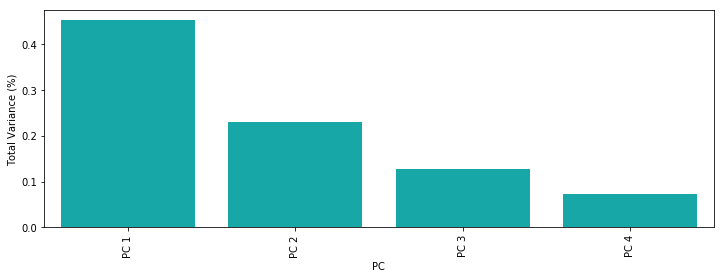

In [119]:
df = pd.DataFrame({'variance':pca.explained_variance_ratio_,
             'PC':pc_columns})


# Plotting the raw Explained Variance
fig = plt.figure(figsize=(12,4))

# first plot
sns.barplot(x='PC',y="variance", 
           data=df, color="c")

plt.ylabel('Total Variance (%)')
plt.xticks(rotation='vertical')
plt.show()

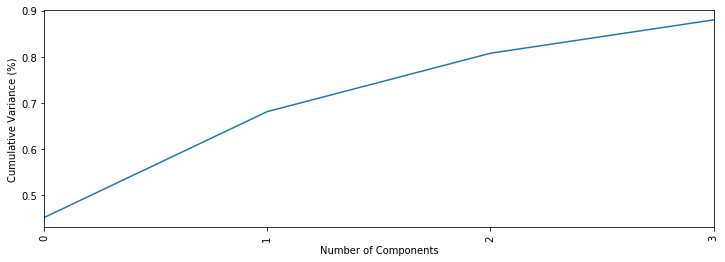

In [120]:
#Plotting the Cumulative Summation of the Explained Variance
fig = plt.figure(figsize=(12,4))

plt.plot(np.cumsum(pca.explained_variance_ratio_))

# clean plot
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance (%)') #for each component
plt.xlim([0,num_pcs-1])
plt.xticks(range(num_pcs),rotation='vertical')

plt.show()

In [121]:
# toss back in the labels from before - I force all to be type str
for col_label in ['Model_ID','Protocol_ID']:
    pc_df[col_label] = pd.Series([str(i) for i in final_pca_df[col_label].values])



In [122]:
pc_df.head()

,PC 1,PC 2,PC 3,PC 4,Model_ID,Protocol_ID
0,-21.038740,-4.415084,-27.097441,-5.043148,NMLCH000014,ACTIVATION
1,-23.239105,-3.067074,-24.934300,-7.200630,NMLCH000017,ACTIVATION
2,-17.306044,-5.838488,-11.386565,-18.619565,NMLCH000066,ACTIVATION
3,-53.719683,36.045617,27.262528,-4.715049,NMLCH000067,ACTIVATION
4,20.335638,-33.590789,7.235361,7.215117,NMLCH000101,ACTIVATION


In [123]:
def plot_pca(pc_df):
    
    fig, ax = plt.subplots(1,3,figsize=(18, 6))
    ax = ax.flatten()

    which_pcs = [(1,2),(1,3),(2,3)]
    total_pc_channels = len(pc_df.index.values)

    for ax_id, (x_axis,y_axis) in enumerate(which_pcs):
        x_pc = 'PC '+str(x_axis)
        y_pc = 'PC '+str(y_axis)

        ax[ax_id].scatter(pc_df.loc[:, x_pc],
                   pc_df.loc[:, y_pc],
                   c = 'r', s = 50,
                   alpha=0.8,edgecolors='gray')


        ax[ax_id].set_xlabel(x_pc)
        ax[ax_id].set_ylabel(y_pc)


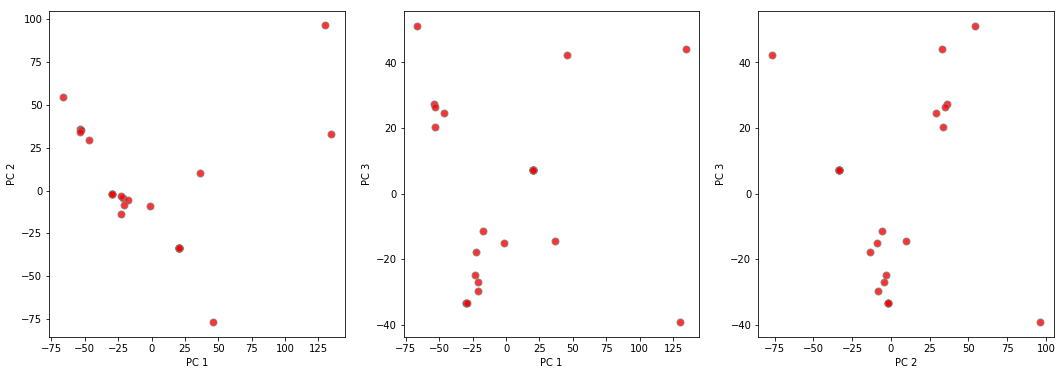

In [124]:
plot_pca(pc_df=pc_df)

### PCA of all voltage-gated channels under DEACTIVATION conditions

In [110]:
final_pca_df = cav_pca_df[cav_pca_df['Protocol_ID']=='DEACTIVATION']

# drop label columns
temp_df = final_pca_df.copy()
df = temp_df.drop(labels=['Model_ID','Protocol_ID'],axis='columns')

# separating out the features
x = df.loc[:].values

# define number of components to use
num_pcs = 6

pca = PCA(n_components=num_pcs)

# standardize the features
x = StandardScaler().fit_transform(x)
pcs = pca.fit_transform(x)


# create pca DataFrame
pc_columns = ['PC '+str(i+1) for i in range(num_pcs)]

pc_df = pd.DataFrame(data = pcs, columns = pc_columns)

In [113]:
pc_df.tail()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6
19,-10.719908,-11.776373,1.923073,5.772541,80.620964,-11.214615
20,43.792780,-59.546419,-49.707528,35.146560,-18.840752,6.876406
21,-28.866242,16.938419,-12.551412,-4.878557,12.974182,5.773784
22,99.722876,53.995851,46.632731,-37.671039,-12.515700,-22.942092
23,-23.848532,-10.444937,11.760008,-22.498258,-3.707873,0.527882


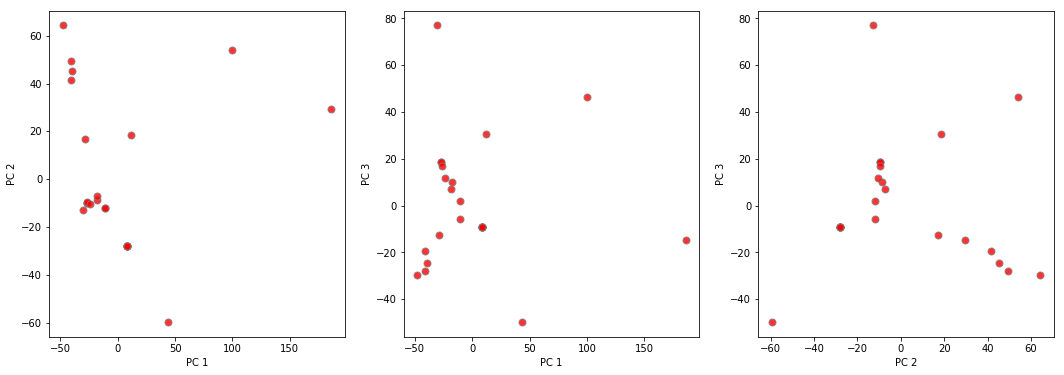

In [114]:
plot_pca(pc_df=pc_df)

### PCA of all voltage-gated channels under INACTIVATION conditions

<b>Notes</b>
> Something mentioned in Ori et al. (2018) "[...] regulation of excitability by
one activity-dependent principle that is tightly related to a
ubiquitous physiological process: slow inactivation of ionic
channels."

In [125]:
final_pca_df = cav_pca_df[cav_pca_df['Protocol_ID']=='INACTIVATION']

# drop label columns
temp_df = final_pca_df.copy()
df = temp_df.drop(labels=['Model_ID','Protocol_ID'],axis='columns')

# separating out the features
x = df.loc[:].values

# define number of components to use
num_pcs = 6

pca = PCA(n_components=num_pcs)

# standardize the features
x = StandardScaler().fit_transform(x)
pcs = pca.fit_transform(x)


# create pca DataFrame
pc_columns = ['PC '+str(i+1) for i in range(num_pcs)]

pc_df = pd.DataFrame(data = pcs, columns = pc_columns)

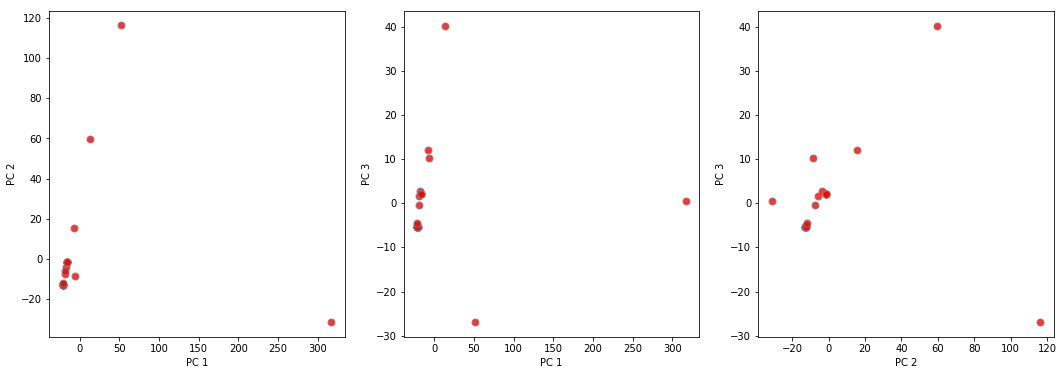

In [126]:
plot_pca(pc_df=pc_df)

### PCA of all calcium-dependent channels under ACTIVATION conditions

In [ ]:
final_pca_df = cad_pca_df[cad_pca_df['Protocol_ID']=='ACTIVATION']

# drop label columns
temp_df = final_pca_df.copy()
df = temp_df.drop(labels=['Model_ID','Protocol_ID'],axis='columns')

# separating out the features
x = df.loc[:].values

# define number of components to use
num_pcs = 60

pca = PCA(n_components=num_pcs)

# standardize the features
x = StandardScaler().fit_transform(x)
pcs = pca.fit_transform(x)


# create pca DataFrame
pc_columns = ['PC '+str(i+1) for i in range(num_pcs)]

pc_df = pd.DataFrame(data = pcs, columns = pc_columns)

### PCA of all calcium-dependent channels under DEACTIVATION conditions

In [ ]:
final_pca_df = cad_pca_df[cad_pca_df['Protocol_ID']=='DEACTIVATION']

# drop label columns
temp_df = final_pca_df.copy()
df = temp_df.drop(labels=['Model_ID','Protocol_ID'],axis='columns')

# separating out the features
x = df.loc[:].values

# define number of components to use
num_pcs = 60

pca = PCA(n_components=num_pcs)

# standardize the features
x = StandardScaler().fit_transform(x)
pcs = pca.fit_transform(x)


# create pca DataFrame
pc_columns = ['PC '+str(i+1) for i in range(num_pcs)]

pc_df = pd.DataFrame(data = pcs, columns = pc_columns)

### PCA of all calcium-dependent channels under INACTIVATION conditions

In [ ]:
final_pca_df = cad_pca_df[cad_pca_df['Protocol_ID']=='INACTIVATION']

# drop label columns
temp_df = final_pca_df.copy()
df = temp_df.drop(labels=['Model_ID','Protocol_ID'],axis='columns')

# separating out the features
x = df.loc[:].values

# define number of components to use
num_pcs = 60

pca = PCA(n_components=num_pcs)

# standardize the features
x = StandardScaler().fit_transform(x)
pcs = pca.fit_transform(x)


# create pca DataFrame
pc_columns = ['PC '+str(i+1) for i in range(num_pcs)]

pc_df = pd.DataFrame(data = pcs, columns = pc_columns)